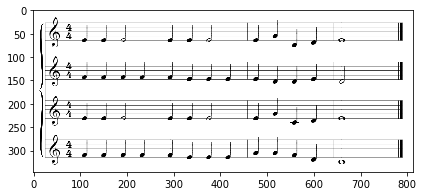

In [516]:
from skimage.filters import sobel_h
from skimage.io import imshow, imread
from skimage.filters import threshold_otsu
from skimage.feature import canny

image = imread('test.jpg', as_gray=True)
used_image = image
imshow(image)

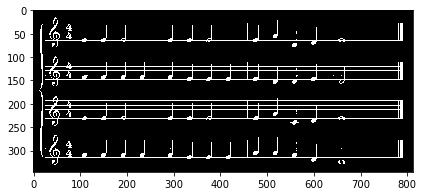

In [517]:
thresh = threshold_otsu(used_image)
used_image = used_image < thresh
imshow(used_image)

In [518]:
# used_image = canny(used_image, sigma=1)
# imshow(used_image)

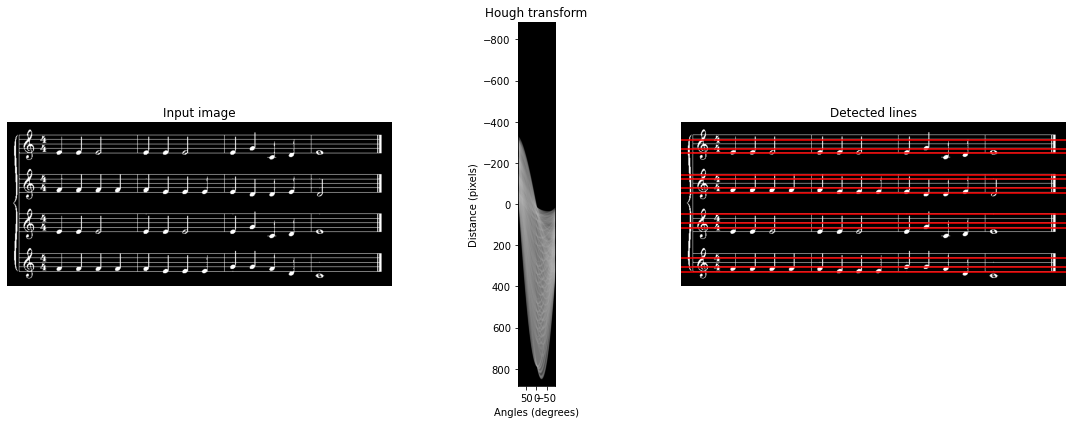

In [519]:
import numpy as np
from skimage.io import imread

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data, transform

import matplotlib.pyplot as plt
from matplotlib import cm


# Constructing test image
# image = sobel_image
# image = sobel_image
# used_image = image > 0.9


# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
h, theta, d = hough_line(used_image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(used_image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(used_image, cmap=cm.gray)
origin = np.array((0, used_image.shape[1]))
angles = []

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    angles.append(angle)
    ax[2].plot(origin, (y0, y1), '-r')

ax[2].set_xlim(origin)
ax[2].set_ylim((used_image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

In [520]:
import math
values, counts = np.unique(angles, return_counts=True)

max_angle = values[np.argmax(counts)]

max_angle = 270 - (max_angle * 180 / math.pi)
print(max_angle)

180.0


180.0


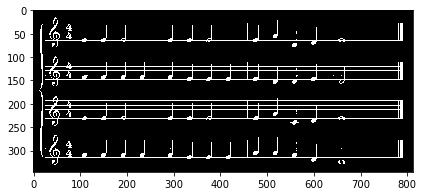

In [521]:
rotated_image = used_image
print(max_angle)
if abs(180 - abs(max_angle)) > 20:
    rotated_image = transform.rotate(used_image, -max_angle, False, cval=0)
imshow(rotated_image)

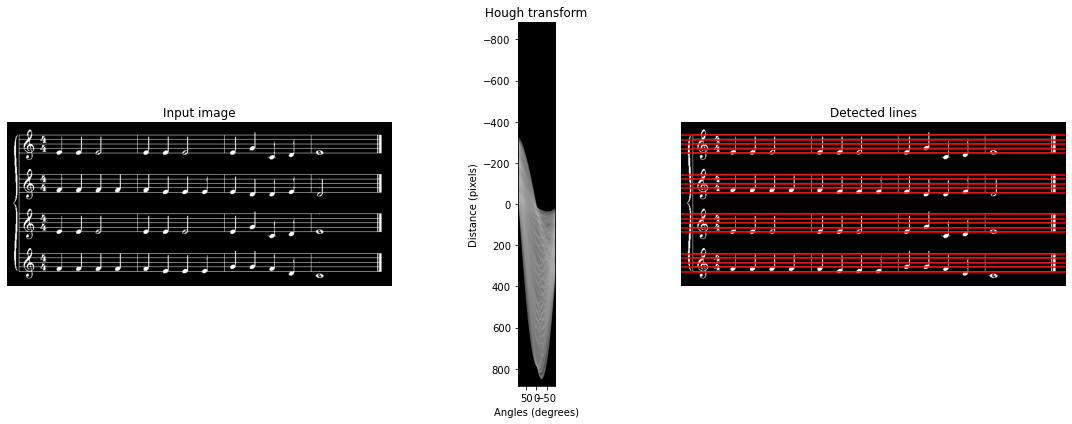

In [522]:
import numpy as np
from skimage.io import imread

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data, transform

import matplotlib.pyplot as plt
from matplotlib import cm


# Constructing test image
# image = sobel_image
# image = sobel_image
# used_image = image > 0.9
used_image = rotated_image


# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
h, theta, d = hough_line(used_image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(used_image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(used_image, cmap=cm.gray)
origin = np.array((0, used_image.shape[1]))
y_locs = []

for _, angle, dist in zip(*hough_line_peaks(h, theta, d, min_distance=5)):
    if abs(90 - abs((angle * 180 / math.pi))) > 30:
        continue
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    y_locs.append((y0 + y1) / 2)
    ax[2].plot(origin, (y0, y1), '-r')

ax[2].set_xlim(origin)
ax[2].set_ylim((used_image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')


# sub_img = used_image[]

plt.tight_layout()
plt.show()

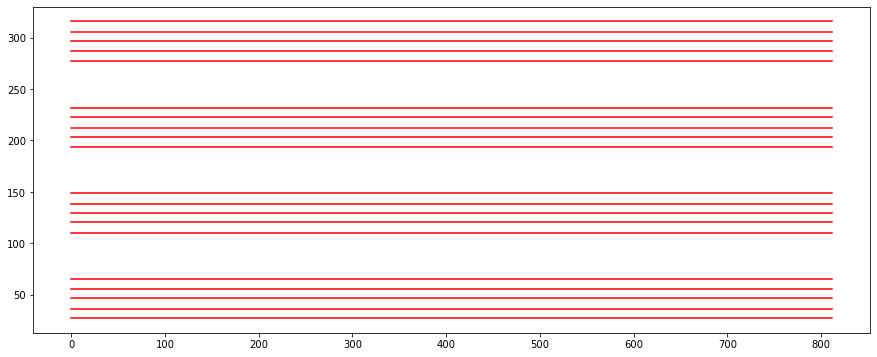

In [523]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

for y in y_locs:
    axes.plot(origin, (y, y), '-r')

In [524]:
sorting = sorted(y_locs)
diffs = []

for i in range(len(sorting) - 1):
    diffs.append(sorting[i + 1] - sorting[i])

temp = sorted(diffs, reverse=True)
thres_o = 0

for i in range(1,len(temp)):
    if(temp[i] > temp [i + 1] * 2):
        thres_o = temp[i]
        break

# thresi = (sorting[-1] - sorting[0]) / len(sorting)

# for i in range(len(sorting) - 1):
#     diffs.add(sorting[i + 1] - sorting[i])
    
# max_value, medi = max(diffs), np.median(list(diffs))

In [525]:
seg_locs = []

for i in range(1, len(sorting) - 1):
    prev_diff = sorting[i] - sorting[i - 1]
    next_diff = sorting[i + 1] - sorting[i]
    
    if next_diff >= (thres_o):
        seg_locs.append((sorting[i + 1] + sorting[i]) / 2)

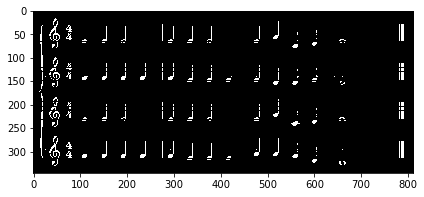

In [526]:
imshow(used_image)
used_image[:][np.uint16(y_locs)] = 0
imshow(used_image)

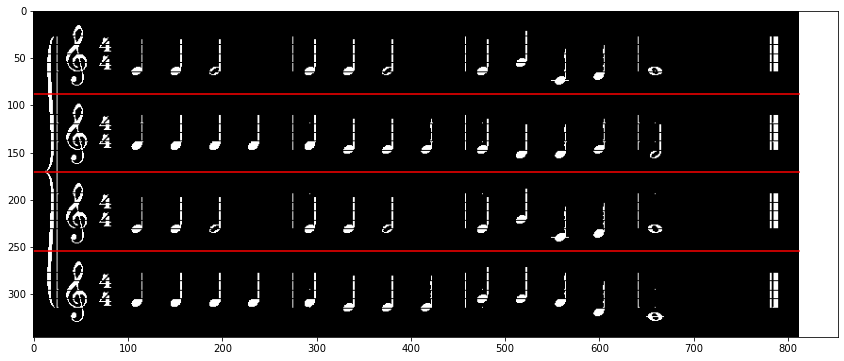

In [527]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

axes.imshow(used_image, cmap=cm.gray)

for loc in seg_locs:
    y0, y1 = loc, loc
    axes.plot(origin, (y0, y1), '-r')

In [528]:
max_diff = float('-inf')
for i in range(len(seg_locs) - 1):
    diff = seg_locs[i + 1] - seg_locs[i]
    max_diff = diff if diff > max_diff else max_diff

In [529]:
seg_locs.append(seg_locs[-1] + max_diff)
seg_locs.insert(0, seg_locs[0] - max_diff)
seg_locs = list(filter(lambda x: 0 < x < used_image.shape[1], seg_locs))

In [530]:
#row_images= np.zeros(shape= (seg_locs.shape-2, ))
row_images = []

for i in range(len(seg_locs) - 1):
    start_loc, end_loc = (int(round(seg_locs[i])), int(round(seg_locs[i + 1])))
    
    row = used_image[start_loc:end_loc][:]
    
    row_images.append(row)

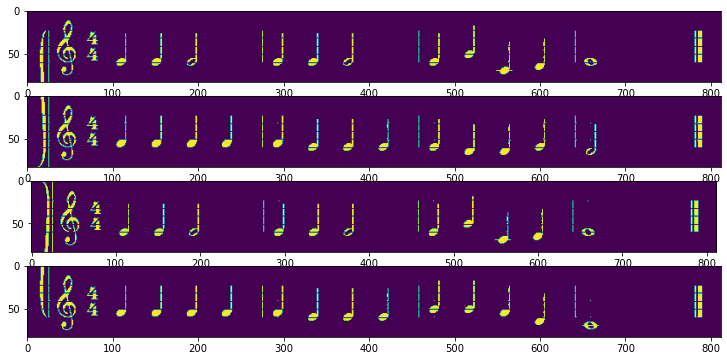

In [531]:
fig, axes = plt.subplots(len(row_images), 1, figsize=(15, 6))

for i in range(len(row_images)):
    axes[i].imshow(row_images[i])

In [532]:
bin_imgs = []
for img in row_images:
    thresh = threshold_otsu(img)
    img = img < thresh
    bin_imgs.append(img)

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


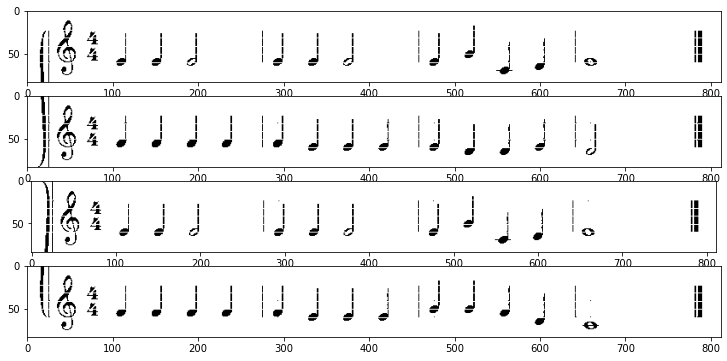

In [533]:
fig, axes = plt.subplots(len(bin_imgs), 1, figsize=(15, 6))

for i in range(len(bin_imgs)):
    axes[i].imshow(bin_imgs[i], cmap=cm.gray)

In [545]:
my_img = bin_imgs[0]
freq = np.sum(my_img,0)
max = np.max(freq)
y,x = my_img.shape
last_false = True;
bounds = []
for i in range(x):
    if freq[i] > max - 3 and last_false:
        last_false = False
        bounds.append(i)
    elif freq[i] < max - 3:
        last_false = True

print(bounds)

[0, 21, 26, 57, 83, 116, 158, 199, 276, 300, 341, 382, 459, 483, 524, 565, 606, 642, 667, 783, 790]


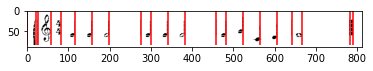

In [556]:
ax = plt.axes()
ax.imshow(my_img, cmap=cm.gray)
for x in bounds:
    ax.vlines(x, 0, my_img.shape[0], colors='r')
plt.show()